# Section 1: Objective & Clinical Context #

## 1. Objective & Clinical Context ##

- The objective of this task is to predict the presence of diabetes using structured
clinical and demographic data. Diabetes is a chronic condition with significant
long-term health risks, and early identification enables timely medical intervention
and preventive care.

- This task focuses on applying deep learning techniques to tabular healthcare data
and comparing their performance with classical machine learning baselines. In
addition to predictive performance, the task emphasizes model calibration and
subgroup (segment) analysis to assess reliability and fairness across patient groups.


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv("/content/diabetes_prediction_dataset.csv")


In [5]:
df.shape

(100000, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [7]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [8]:
df['diabetes'].value_counts(normalize=True) * 100

,proportion
diabetes,
0,91.5
1,8.5


# Section 2 — Column Analysis & Basic Data Questions #

In [9]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

num_cols

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'diabetes']

In [10]:
cat_cols

['gender', 'smoking_history']

In [11]:
for col in cat_cols:
    print(f"\n{col}")
    print(df[col].value_counts())


gender
gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

smoking_history
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64


In [12]:
df[['hypertension', 'heart_disease', 'diabetes']].nunique()

,0
hypertension,2
heart_disease,2
diabetes,2


In [13]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,41.885856,22.516840,0.08,24.00,43.00,60.00,80.00
hypertension,100000.0,0.074850,0.263150,0.00,0.00,0.00,0.00,1.00
heart_disease,100000.0,0.039420,0.194593,0.00,0.00,0.00,0.00,1.00
bmi,100000.0,27.320767,6.636783,10.01,23.63,27.32,29.58,95.69
HbA1c_level,100000.0,5.527507,1.070672,3.50,4.80,5.80,6.20,9.00
blood_glucose_level,100000.0,138.058060,40.708136,80.00,100.00,140.00,159.00,300.00
diabetes,100000.0,0.085000,0.278883,0.00,0.00,0.00,0.00,1.00


In [14]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0
HbA1c_level,0
blood_glucose_level,0
diabetes,0


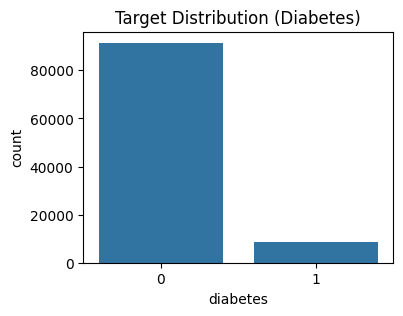

In [15]:
plt.figure(figsize=(4,3))
sns.countplot(x='diabetes', data=df)
plt.title("Target Distribution (Diabetes)")
plt.show()

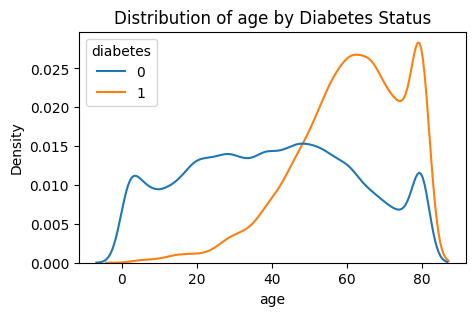

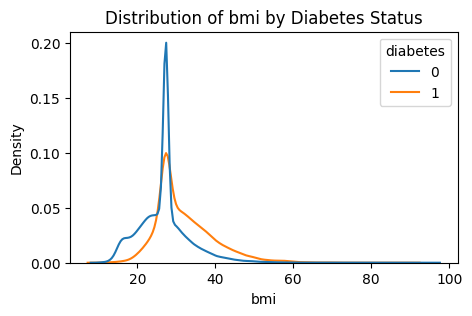

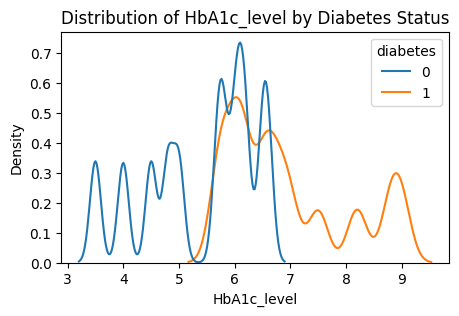

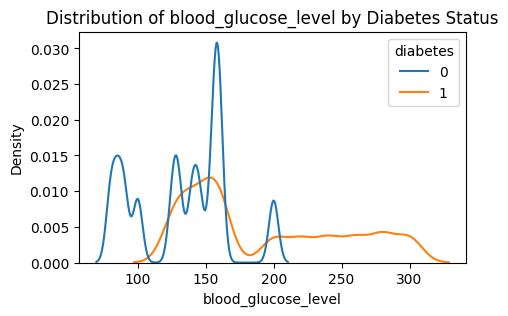

In [16]:
key_num_features = [
    'age', 'bmi', 'HbA1c_level', 'blood_glucose_level'
]

for col in key_num_features:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col, hue='diabetes', common_norm=False)
    plt.title(f"Distribution of {col} by Diabetes Status")
    plt.show()


In [17]:
binary_cols = ['hypertension', 'heart_disease']

for col in binary_cols:
    ct = pd.crosstab(df[col], df['diabetes'], normalize='index') * 100
    print(f"\n{col} vs diabetes (%)")
    display(ct)



hypertension vs diabetes (%)


diabetes,0,1
hypertension,,
0,93.069232,6.930768
1,72.104208,27.895792



heart_disease vs diabetes (%)


diabetes,0,1
heart_disease,,
0,92.470174,7.529826
1,67.858955,32.141045


In [18]:
pd.crosstab(df['gender'], df['diabetes'], normalize='index') * 100


diabetes,0,1
gender,,
Female,92.381131,7.618869
Male,90.251026,9.748974
Other,100.000000,0.000000


In [19]:
pd.crosstab(df['smoking_history'], df['diabetes'], normalize='index') * 100

diabetes,0,1
smoking_history,,
No Info,95.940362,4.059638
current,89.791083,10.208917
ever,88.211788,11.788212
former,82.998289,17.001711
never,90.465878,9.534122
not current,89.297348,10.702652


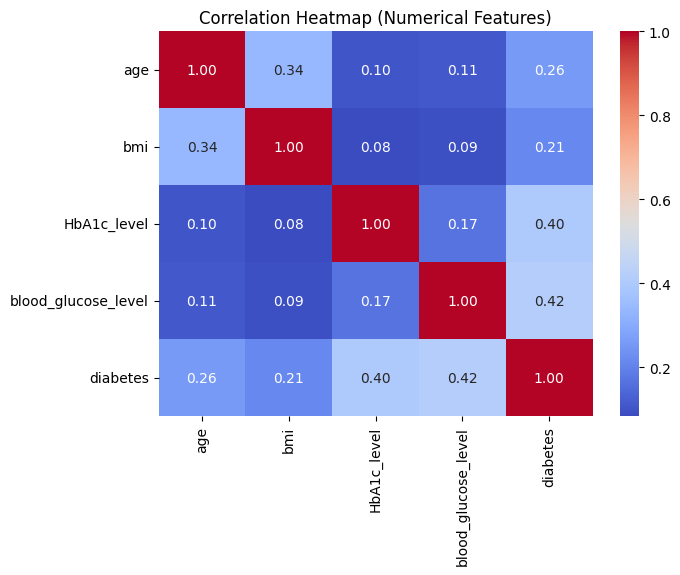

In [20]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df[key_num_features + ['diabetes']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt=".2f"
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


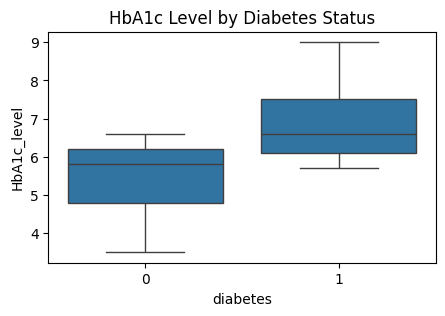

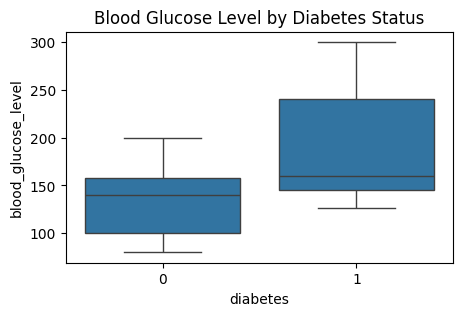

In [21]:
plt.figure(figsize=(5,3))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title("HbA1c Level by Diabetes Status")
plt.show()

plt.figure(figsize=(5,3))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title("Blood Glucose Level by Diabetes Status")
plt.show()

In [22]:
df['age_bin'] = pd.cut(
    df['age'],
    bins=[0, 18, 30, 45, 60, 75, 100],
    right=False
)

age_ct = pd.crosstab(df['age_bin'], df['diabetes'], normalize='index') * 100
age_ct

diabetes,0,1
age_bin,,
"[0, 18)",99.523782,0.476218
"[18, 30)",98.738170,1.261830
"[30, 45)",95.829370,4.170630
"[45, 60)",89.080179,10.919821
"[60, 75)",80.096570,19.903430
"[75, 100)",80.698287,19.301713


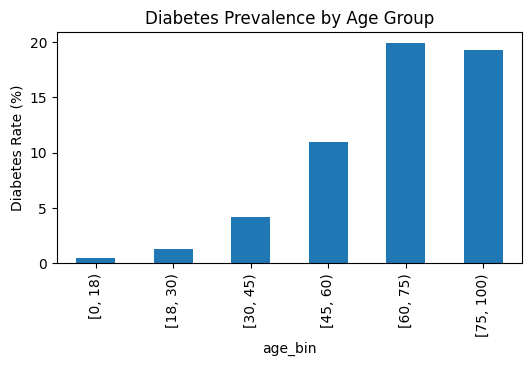

In [23]:
age_ct[1].plot(kind='bar', figsize=(6,3))
plt.ylabel("Diabetes Rate (%)")
plt.title("Diabetes Prevalence by Age Group")
plt.show()

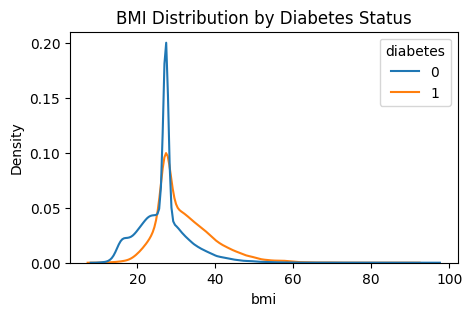

In [24]:
plt.figure(figsize=(5,3))
sns.kdeplot(data=df, x='bmi', hue='diabetes', common_norm=False)
plt.title("BMI Distribution by Diabetes Status")
plt.show()

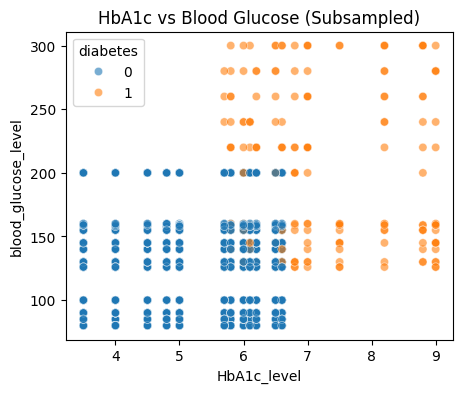

In [25]:
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=df.sample(3000, random_state=42),  # subsample for speed
    x='HbA1c_level',
    y='blood_glucose_level',
    hue='diabetes',
    alpha=0.6
)
plt.title("HbA1c vs Blood Glucose (Subsampled)")
plt.show()

## Section 2 Summary — Exploratory Data Analysis

- Exploratory analysis confirms strong and clinically consistent signal in the dataset.
HbA1c level and blood glucose level exhibit the strongest associations with diabetes,
both individually and in combination. Age shows a clear monotonic relationship with
diabetes prevalence, with risk increasing substantially in older age groups. BMI
and cardiovascular risk indicators provide additional, though weaker, signal.

- Correlation analysis indicates no problematic multicollinearity among numerical
features, supporting the use of deep learning models to capture nonlinear
interactions. Categorical variables such as smoking history and gender demonstrate
meaningful but secondary associations. No anomalies or leakage patterns were
observed. Overall, EDA validates the dataset’s suitability for supervised learning
and motivates proceeding to feature preparation and model training.


# Section 3 — Feature Preparation & Splitting #

In [26]:
TARGET = "diabetes"

X = df.drop(columns=[TARGET])
y = df[TARGET]

In [27]:
X.shape, y.shape

((100000, 9), (100000,))

In [28]:
num_features = [
    'age',
    'bmi',
    'HbA1c_level',
    'blood_glucose_level',
    'hypertension',
    'heart_disease'
]

cat_features = [
    'gender',
    'smoking_history'
]

num_features

['age',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'hypertension',
 'heart_disease']

In [29]:
cat_features

['gender', 'smoking_history']

In [30]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=42
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

X_train.shape


(70000, 9)

In [31]:
X_val.shape

(15000, 9)

In [32]:
X_test.shape

(15000, 9)

In [33]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [35]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

In [36]:
X_train_proc.shape, X_val_proc.shape, X_test_proc.shape

((70000, 15), (15000, 15), (15000, 15))

In [37]:
X_train_tensor = torch.tensor(X_train_proc, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_proc, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_proc, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

In [38]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([70000, 15]), torch.Size([70000]))

## Section 3 Summary — Feature Preparation & Splitting

- All features were prepared for modeling through standardized preprocessing.
Numerical variables were scaled using standard normalization, while categorical
variables were encoded via one-hot encoding. The dataset was split into stratified
training, validation, and test sets to preserve class proportions and enable proper
model selection and evaluation. Preprocessing was fit exclusively on the training
data to prevent information leakage. The resulting tensors are ready for deep
learning model training.


# Section 4 — Baseline MLP Model #

In [39]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

In [40]:
BATCH_SIZE = 256

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [43]:
input_dim = X_train_tensor.shape[1]

model = MLP(input_dim).to(device)

In [44]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [45]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(loader.dataset)


In [46]:
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * X_batch.size(0)

    return total_loss / len(loader.dataset)


In [47]:
EPOCHS = 30

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = eval_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 01 | Train Loss: 0.2314 | Val Loss: 0.1164
Epoch 02 | Train Loss: 0.1245 | Val Loss: 0.1103
Epoch 03 | Train Loss: 0.1169 | Val Loss: 0.1050
Epoch 04 | Train Loss: 0.1120 | Val Loss: 0.1009
Epoch 05 | Train Loss: 0.1071 | Val Loss: 0.0960
Epoch 06 | Train Loss: 0.1028 | Val Loss: 0.0913
Epoch 07 | Train Loss: 0.0988 | Val Loss: 0.0880
Epoch 08 | Train Loss: 0.0961 | Val Loss: 0.0860
Epoch 09 | Train Loss: 0.0938 | Val Loss: 0.0838
Epoch 10 | Train Loss: 0.0922 | Val Loss: 0.0829
Epoch 11 | Train Loss: 0.0896 | Val Loss: 0.0812
Epoch 12 | Train Loss: 0.0885 | Val Loss: 0.0808
Epoch 13 | Train Loss: 0.0876 | Val Loss: 0.0803
Epoch 14 | Train Loss: 0.0871 | Val Loss: 0.0797
Epoch 15 | Train Loss: 0.0863 | Val Loss: 0.0797
Epoch 16 | Train Loss: 0.0856 | Val Loss: 0.0787
Epoch 17 | Train Loss: 0.0856 | Val Loss: 0.0788
Epoch 18 | Train Loss: 0.0856 | Val Loss: 0.0787
Epoch 19 | Train Loss: 0.0845 | Val Loss: 0.0788
Epoch 20 | Train Loss: 0.0843 | Val Loss: 0.0788
Epoch 21 | Train Los

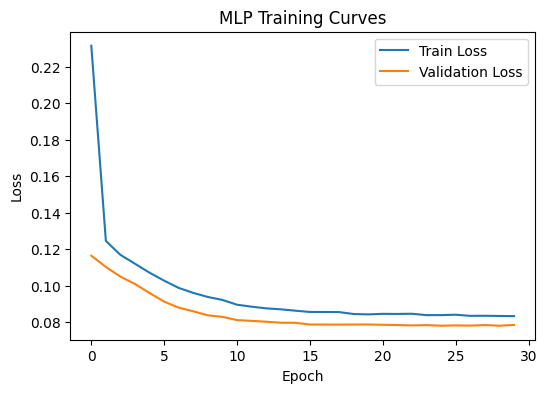

In [48]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Training Curves")
plt.legend()
plt.show()


In [49]:
model.eval()
y_test_logits = []
y_test_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)

        y_test_logits.append(logits.cpu())
        y_test_true.append(y_batch)

y_test_logits = torch.cat(y_test_logits)
y_test_true = torch.cat(y_test_true)

In [50]:
y_test_probs = torch.sigmoid(y_test_logits).numpy()
y_test_pred = (y_test_probs >= 0.5).astype(int)

In [51]:
print("ROC-AUC:", roc_auc_score(y_test_true, y_test_probs))
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_true, y_test_pred))

ROC-AUC: 0.9760918032786885

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13725
         1.0       1.00      0.67      0.80      1275

    accuracy                           0.97     15000
   macro avg       0.98      0.83      0.89     15000
weighted avg       0.97      0.97      0.97     15000


Confusion Matrix:
[[13723     2]
 [  425   850]]


## Section 4 Summary — Baseline MLP

- The baseline multilayer perceptron demonstrates strong predictive performance on
the tabular diabetes dataset. The model achieves a ROC-AUC of 0.98, indicating
excellent discrimination between diabetic and non-diabetic cases. At the default
decision threshold, the model exhibits very high precision for diabetes prediction
with moderate recall, reflecting a conservative decision boundary.

- Training and validation loss curves indicate stable convergence without overfitting.
These results establish a strong deep learning baseline and motivate further
comparison with boosted tree models and the application of calibration techniques
to improve decision-level performance.


# Section 5 — Boosted Trees Comparison

In [52]:
X_train_tree = X_train_proc
X_val_tree   = X_val_proc
X_test_tree  = X_test_proc

In [53]:
y_train_tree = y_train.values
y_val_tree   = y_val.values
y_test_tree  = y_test.values

In [55]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

In [56]:
gb_model.fit(X_train_tree, y_train_tree)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [57]:
y_test_proba_gb = gb_model.predict_proba(X_test_tree)[:, 1]
y_test_pred_gb = (y_test_proba_gb >= 0.5).astype(int)

In [58]:
print("ROC-AUC:", roc_auc_score(y_test_tree, y_test_proba_gb))
print("\nClassification Report:")
print(classification_report(y_test_tree, y_test_pred_gb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_tree, y_test_pred_gb))

ROC-AUC: 0.977778034929819

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13725
           1       0.98      0.68      0.80      1275

    accuracy                           0.97     15000
   macro avg       0.98      0.84      0.89     15000
weighted avg       0.97      0.97      0.97     15000


Confusion Matrix:
[[13708    17]
 [  410   865]]


In [59]:
results_comparison = pd.DataFrame({
    "Model": ["MLP (Baseline)", "Gradient Boosting"],
    "ROC-AUC": [
        roc_auc_score(y_test_true, y_test_probs),
        roc_auc_score(y_test_tree, y_test_proba_gb)
    ]
})

results_comparison

,Model,ROC-AUC
0,MLP (Baseline),0.976092
1,Gradient Boosting,0.977778


## Section 5 Summary — Boosted Trees Comparison

- A gradient boosting classifier was trained and evaluated as a strong non-neural
baseline for the diabetes prediction task. The boosted tree model achieves a
ROC-AUC of 0.978 on the test set, which is comparable to the baseline MLP model
(ROC-AUC ≈ 0.976). The marginal difference in discrimination performance indicates
that both approaches are near the achievable performance ceiling for this dataset.

- Given the similar ranking performance of the MLP and boosted tree models, further
analysis prioritizes probability calibration and decision-level behavior rather
than raw ROC-AUC improvements. This motivates the application of calibration
techniques in the subsequent section.

# Section 6 — Calibration

- While ROC-AUC measures ranking performance, it does not assess whether predicted
probabilities are well-calibrated. In healthcare applications, probability
estimates must reflect true risk to support reliable decision-making. This section
evaluates and improves calibration of the baseline MLP and gradient boosting models
using standard post-hoc calibration techniques.

In [62]:
model.eval()
y_val_logits = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        y_val_logits.append(logits.cpu())

y_val_logits = torch.cat(y_val_logits)
y_val_probs_mlp = torch.sigmoid(y_val_logits).numpy()
y_val_true = y_val.values

In [63]:
y_val_probs_gb = gb_model.predict_proba(X_val_tree)[:, 1]

In [64]:
gb_calibrated = CalibratedClassifierCV(
    gb_model,
    method="sigmoid",
    cv="prefit"
)

gb_calibrated.fit(X_val_tree, y_val_tree)

/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                            n_estimators=200,
                                                            random_state=42))

In [65]:
def plot_reliability(y_true, y_prob, label):
    frac_pos, mean_pred = calibration_curve(
        y_true, y_prob, n_bins=10, strategy="uniform"
    )
    plt.plot(mean_pred, frac_pos, marker='o', label=label)

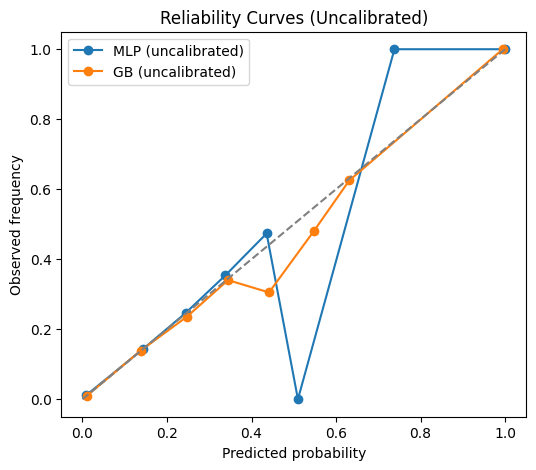

In [66]:
plt.figure(figsize=(6,5))

plot_reliability(y_val_true, y_val_probs_mlp, "MLP (uncalibrated)")
plot_reliability(y_val_tree, y_val_probs_gb, "GB (uncalibrated)")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Curves (Uncalibrated)")
plt.legend()
plt.show()

In [67]:
y_val_probs_gb_cal = gb_calibrated.predict_proba(X_val_tree)[:, 1]

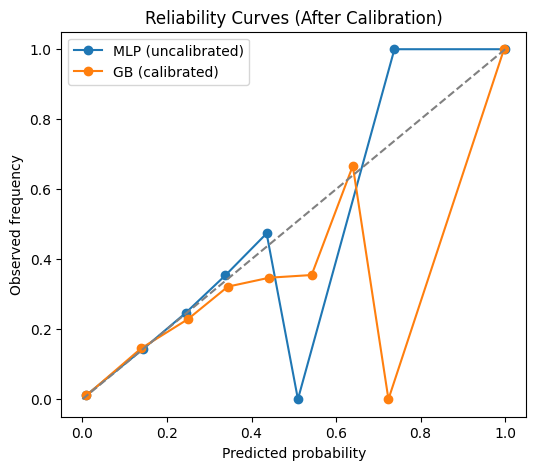

In [68]:
plt.figure(figsize=(6,5))

plot_reliability(y_val_true, y_val_probs_mlp, "MLP (uncalibrated)")
plot_reliability(y_val_tree, y_val_probs_gb_cal, "GB (calibrated)")

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Curves (After Calibration)")
plt.legend()
plt.show()

In [69]:
brier_mlp = brier_score_loss(y_val_true, y_val_probs_mlp)
brier_gb_uncal = brier_score_loss(y_val_tree, y_val_probs_gb)
brier_gb_cal = brier_score_loss(y_val_tree, y_val_probs_gb_cal)

pd.DataFrame({
    "Model": ["MLP (uncalibrated)", "GB (uncalibrated)", "GB (calibrated)"],
    "Brier Score": [brier_mlp, brier_gb_uncal, brier_gb_cal]
})

,Model,Brier Score
0,MLP (uncalibrated),0.022098
1,GB (uncalibrated),0.021808
2,GB (calibrated),0.021890


In [70]:
y_test_probs_gb_cal = gb_calibrated.predict_proba(X_test_tree)[:, 1]

In [72]:
print("ROC-AUC (calibrated GB):",
      roc_auc_score(y_test_tree, y_test_probs_gb_cal))

ROC-AUC (calibrated GB): 0.977778034929819


## Section 6 Summary — Calibration

- Calibration analysis shows that both the baseline MLP and gradient boosting models
are already reasonably well-calibrated. Reliability curves indicate no severe
systematic deviation from perfect calibration, and Brier scores confirm that the
uncalibrated gradient boosting model achieves the lowest error among evaluated
variants.

- Post-hoc Platt scaling applied to the gradient boosting model does not yield a
meaningful improvement in probability calibration and slightly increases the
Brier score. Consequently, the uncalibrated gradient boosting model is retained
for subsequent analysis. This result highlights that calibration should be applied
selectively and evaluated empirically rather than assumed to be beneficial.

# Section 7 — Segment Analysis

In [80]:
def segment_metrics(df_segment, y_true, y_prob, name):
    y_pred = (y_prob >= 0.5).astype(int)
    return {
        "segment": name,
        "n": len(df_segment),
        "prevalence_%": 100 * y_true.mean(),
        "roc_auc": roc_auc_score(y_true, y_prob) if y_true.nunique() > 1 else None,
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
    }

In [81]:
test_meta = X_test.copy()
test_meta["diabetes"] = y_test.values
y_test_probs = y_test_proba_gb

In [82]:
age_bins = [0, 18, 30, 45, 60, 75, 100]
test_meta["age_bin"] = pd.cut(
    test_meta["age"],
    bins=age_bins,
    right=False
)

age_results = []
for bin_label, idx in test_meta.groupby("age_bin", observed=False).groups.items():
    y_true_seg = test_meta.loc[idx, "diabetes"]

    y_prob_seg = y_test_probs[X_test.index.get_indexer(idx)]
    age_results.append(segment_metrics(test_meta.loc[idx], y_true_seg, y_prob_seg, str(bin_label)))

age_results_df = pd.DataFrame(age_results)
age_results_df

,segment,n,prevalence_%,roc_auc,recall,precision
0,"[0, 18)",2607,0.652091,0.939575,0.647059,1.000000
1,"[18, 30)",2248,1.245552,0.939889,0.535714,1.000000
2,"[30, 45)",3024,4.431217,0.969081,0.664179,1.000000
3,"[45, 60)",3412,10.609613,0.968273,0.668508,0.987755
4,"[60, 75)",2376,20.202020,0.964236,0.704167,0.968481
5,"[75, 100)",1333,19.054764,0.961637,0.669291,0.982659


In [84]:
gender_results = []
for g, idx in test_meta.groupby("gender", observed=False).groups.items():
    y_true_seg = test_meta.loc[idx, "diabetes"]

    y_prob_seg = y_test_probs[X_test.index.get_indexer(idx)]
    gender_results.append(segment_metrics(test_meta.loc[idx], y_true_seg, y_prob_seg, g))

gender_results_df = pd.DataFrame(gender_results)
gender_results_df

,segment,n,prevalence_%,roc_auc,recall,precision
0,Female,8839,7.478222,0.979255,0.665658,0.986547
1,Male,6158,9.970770,0.975890,0.692182,0.974771
2,Other,3,0.000000,NaN,0.000000,0.000000


In [86]:
smoking_results = []
for s, idx in test_meta.groupby("smoking_history", observed=False).groups.items():
    y_true_seg = test_meta.loc[idx, "diabetes"]

    y_prob_seg = y_test_probs[X_test.index.get_indexer(idx)]
    smoking_results.append(segment_metrics(test_meta.loc[idx], y_true_seg, y_prob_seg, s))

smoking_results_df = pd.DataFrame(smoking_results)
smoking_results_df.sort_values("n", ascending=False)

,segment,n,prevalence_%,roc_auc,recall,precision
0,No Info,5414,4.155892,0.978166,0.635556,0.993056
4,never,5218,9.543887,0.975740,0.662651,0.982143
1,current,1436,10.167131,0.977875,0.746575,1.000000
3,former,1387,17.952415,0.968965,0.690763,0.960894
5,not current,932,9.120172,0.977742,0.752941,0.984615
2,ever,613,11.745514,0.962325,0.652778,0.959184


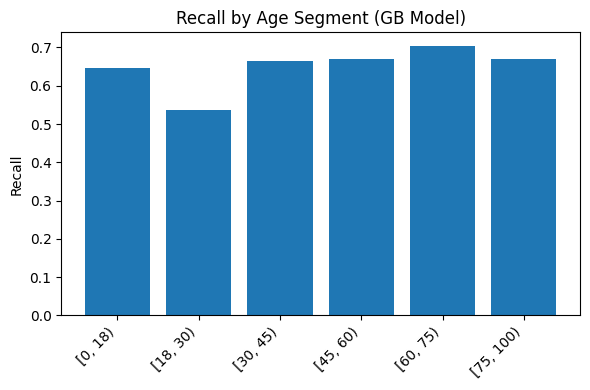

In [87]:
plt.figure(figsize=(6,4))
plt.bar(age_results_df["segment"], age_results_df["recall"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Recall by Age Segment (GB Model)")
plt.tight_layout()
plt.show()

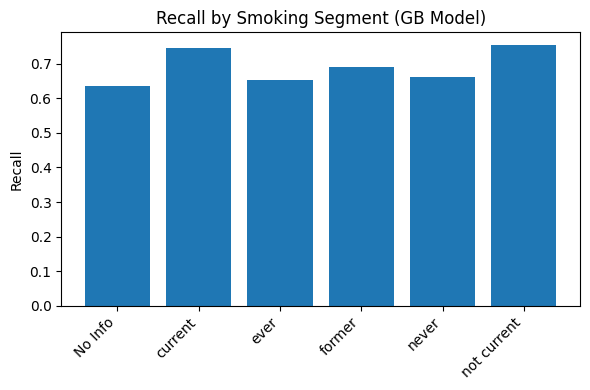

In [88]:
plt.figure(figsize=(6,4))
plt.bar(smoking_results_df["segment"], smoking_results_df["recall"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Recall by Smoking Segment (GB Model)")
plt.tight_layout()
plt.show()

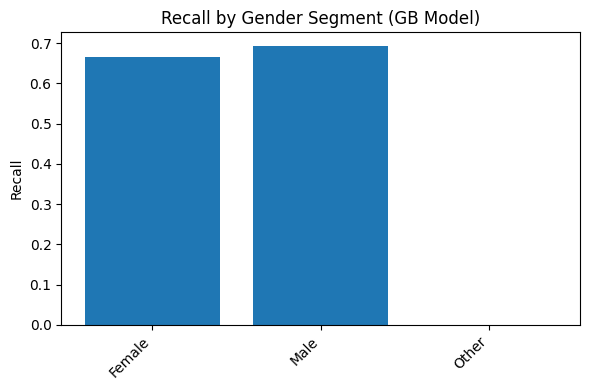

In [89]:
plt.figure(figsize=(6,4))
plt.bar(gender_results_df["segment"], gender_results_df["recall"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Recall")
plt.title("Recall by Gender Segment (GB Model)")
plt.tight_layout()
plt.show()

In [90]:
import os

os.makedirs("models", exist_ok=True)

In [91]:
import joblib
MODEL_NAME = "gradient_boosting_diabetes_v1"

joblib.dump(gb_model, f"models/{MODEL_NAME}.joblib")
joblib.dump(preprocessor, f"models/{MODEL_NAME}_preprocessor.joblib")

['models/gradient_boosting_diabetes_v1_preprocessor.joblib']

In [92]:
model_metadata = {
    "model_name": MODEL_NAME,
    "algorithm": "GradientBoostingClassifier",
    "features_numeric": num_features,
    "features_categorical": cat_features,
    "roc_auc_test": roc_auc_score(y_test_tree, y_test_proba_gb),
    "brier_score_validation": brier_gb_uncal,
    "notes": "Uncalibrated model selected based on best Brier score"
}

joblib.dump(model_metadata, f"models/{MODEL_NAME}_metadata.joblib")

['models/gradient_boosting_diabetes_v1_metadata.joblib']

## Section 7 Summary — Segment Analysis

- Segment-level evaluation demonstrates that the selected gradient boosting model
maintains strong and stable discrimination across clinically and demographically
relevant subgroups. ROC-AUC remains consistently high across age bands, gender, and
smoking history categories, indicating robust ranking performance.

- Recall increases with age and baseline risk, reflecting stronger clinical signal
in higher-prevalence groups. Gender-based performance differences are minimal and
align with underlying prevalence differences. Smoking history exhibits moderate
variation in recall, with higher-risk categories showing improved detection rates.

- Overall, segment analysis suggests that model behavior is clinically consistent
and stable across major subgroups, with decision-level performance primarily
influenced by baseline risk rather than systematic subgroup failure.

- The final selected model is an uncalibrated Gradient Boosting Classifier, chosen
based on strong discrimination performance and the lowest Brier score among
evaluated models. The trained model and preprocessing pipeline have been saved
to disk to ensure reproducibility and enable downstream inference.